# Chiral spectra of carbon dots and PCA

## glutathion with formamide

Read about PCA https://nirpyresearch.com/classification-nir-spectra-principal-component-analysis-python/

Data from E.Ushakova and E.Stepanidenko, PhysNano, ITMO University.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import StandardScaler

В исходном файле первая колонка — длины волн, спектры образцов начинаются с 10-й колонки.
В датафрейме работа идет со строками, поэтому данные из файла дополнительно транспонируются.

In [2]:
path = './data/'

df_temp = pd.read_csv(path + 'glutathione' + '.csv', sep=',')

df_trans = df_temp.T

#df_trans.to_csv('./data/' + 'glutathione_t' + '.csv')

wl = df_trans.values[0, 9:]
wl = wl.astype('int')

spectra = df_trans.values[1:, 9:].astype('float')
spectra_sm = savgol_filter(spectra, 25, polyorder = 5, deriv=0)

Имена образцов тоже из файла добываются.

In [3]:
labplot = []
for i in range(df_trans.shape[0] - 1):
    labplot.append(df_trans.values[i + 1, 2] + ' ' + df_trans.values[i + 1, 3])

colors = [plt.cm.jet(float(i)/len(labplot)) for i in range(len(labplot))]

# or one color for every group, better take names from labels
groups = [None] * 4
groups[0] = [i for i in range(0,8)]
groups[1] = [i for i in range(8,13)]
groups[2] = [i for i in range(13,18)]
groups[3] = [i for i in range(18,21)]

colors = [None] * len(labplot)

for n, i in enumerate(groups):
    for j in i:
        colors[j] = plt.cm.jet(float(n)/len(groups))

Исходные спектры:

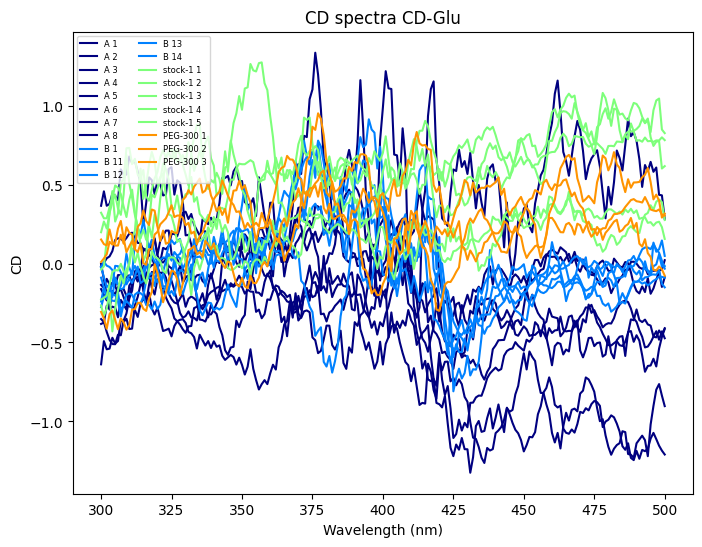

In [4]:
fig = plt.figure(figsize=(8,6))

for i in range(len(labplot)):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    plt.plot(wl, spectra[i,:].T, c=col, label=labplot[i])
plt.xlabel('Wavelength (nm)')
plt.ylabel('CD')
plt.legend(labplot,loc='upper left', ncol=2, fontsize="6")
plt.title('CD spectra CD-Glu')
plt.show()

Если усреднить спектры по группам то уже можно видеть разницу:

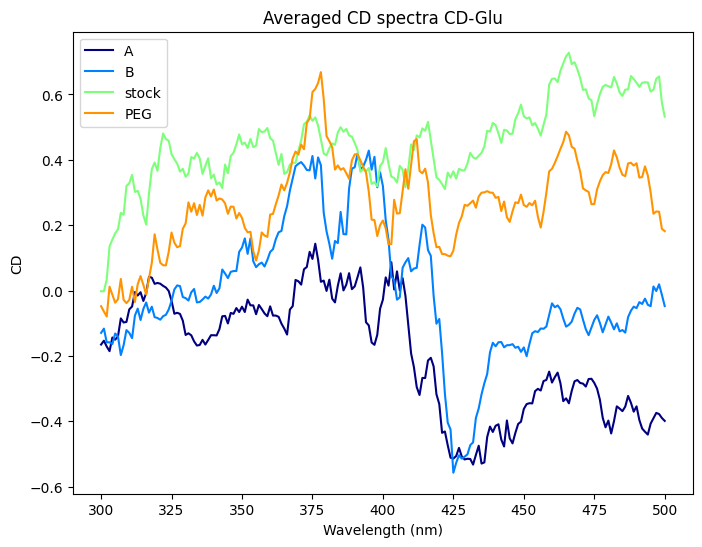

In [5]:
fig = plt.figure(figsize=(8,6))

labels = ['A', 'B', 'stock', 'PEG']

for n, i in enumerate(groups):
    col = np.expand_dims(np.array(colors[groups[n][0]]), axis=0)
    plt.plot(wl, spectra[groups[n],:].mean(0).T, c=col, label=labels[n])
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('CD')
plt.legend(loc='upper left')
plt.title('Averaged CD spectra CD-Glu')
plt.show()

Можно сгладить и каждую кривую. по-отдельности: 

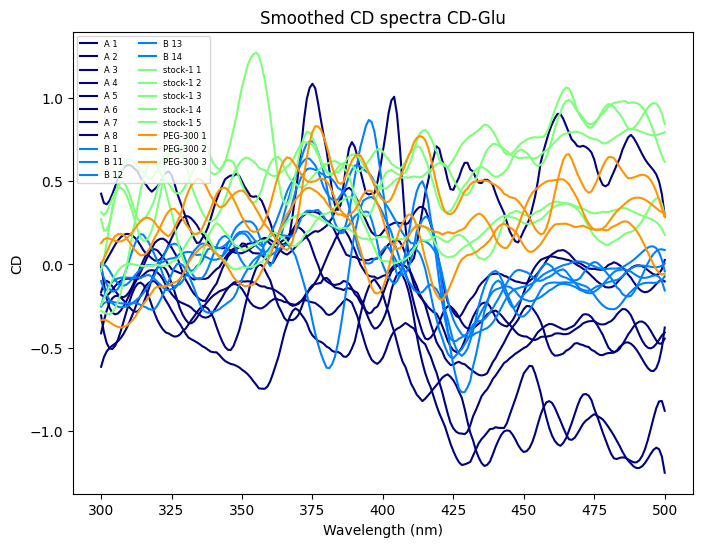

In [6]:
fig = plt.figure(figsize=(8,6))

for i in range(len(labplot)):
    col = np.expand_dims(np.array(colors[i]), axis=0)
    plt.plot(wl, spectra_sm[i,:].T, c=col, label=labplot[i])
plt.xlabel('Wavelength (nm)')
plt.ylabel('CD')
plt.legend(labplot,loc='upper left', ncol=2, fontsize="6")
plt.title('Smoothed CD spectra CD-Glu')
plt.show()

Предварительно данные надо нормализовать. Есть разные варианты

https://stackoverflow.com/questions/39120942/difference-between-standardscaler-and-normalizer-in-sklearn-preprocessing
 https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a0

Нормализуем дополнительно и производную, хотя тут данные очень шумные и производная не поможет, скорее наоборот.2

In [7]:
n_spectra_sm = StandardScaler().fit_transform(spectra_sm)

dspectra_sm = savgol_filter(spectra, 25, polyorder = 5, deriv=1)
n_dspectra_sm = StandardScaler().fit_transform(dspectra_sm)

Смотрим сколько нужно задавать компонент для PCA

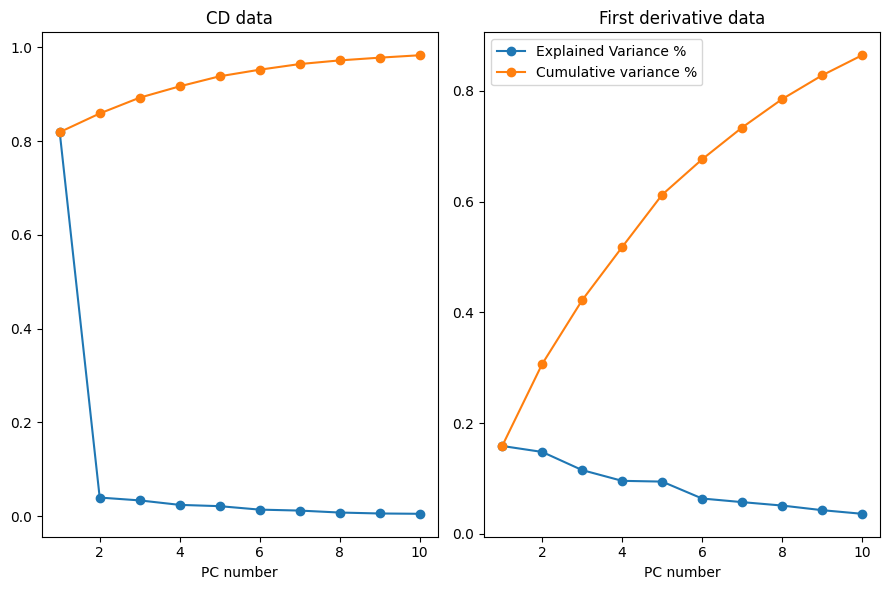

In [8]:
nc = 10
pca1 = pca(n_components=nc)
pca2 = pca(n_components=nc)
 
 
# Fit the spectral data and extract the explained variance ratio
X1 = pca1.fit(n_spectra_sm)
expl_var_1 = X1.explained_variance_ratio_

X2 = pca2.fit(n_dspectra_sm)
expl_var_2 = X2.explained_variance_ratio_

pc_array = np.linspace(1,nc,nc)
#with plt.style.context(('ggplot')):
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
fig.set_tight_layout(True)

ax1.plot(pc_array, expl_var_1,'-o', label="Explained Variance %")
ax1.plot(pc_array, np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
ax1.set_xlabel("PC number")
ax1.set_title('CD data')

ax2.plot(pc_array, expl_var_2,'-o', label="Explained Variance %")
ax2.plot(pc_array, np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
ax2.set_xlabel("PC number")
ax2.set_title('First derivative data')

plt.legend()
plt.show()

С производными много компонент потребуется ...

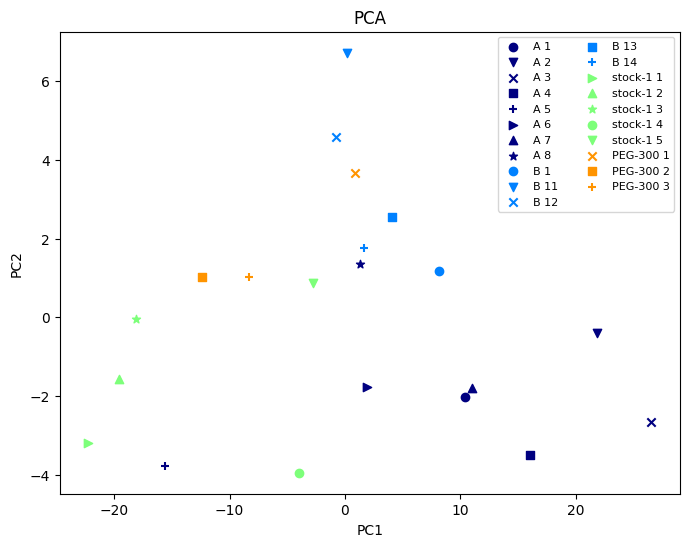

In [9]:
nc = 5
pca2 = pca(n_components=nc)
 
# Transform on the scaled features
Xt2 = pca2.fit_transform(n_spectra_sm)


# Разные стили точек, чтобы циклом по-очереди присваивались и проще различать было бы.
symb = ['o','v','x','s','+','>','^','*'] 

plt.figure(figsize=(8,6))
for j in range(len(Xt2[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    xi = Xt2[j,0]
    yi = Xt2[j,1]
    plt.scatter(xi, yi, c=col, label=labplot[j], marker = symb[j % len(symb)])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labplot, ncol=2, fontsize="8")
plt.title('PCA')
plt.show()

Можно добавить алгоритм для того чтобы выделить группы
https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/

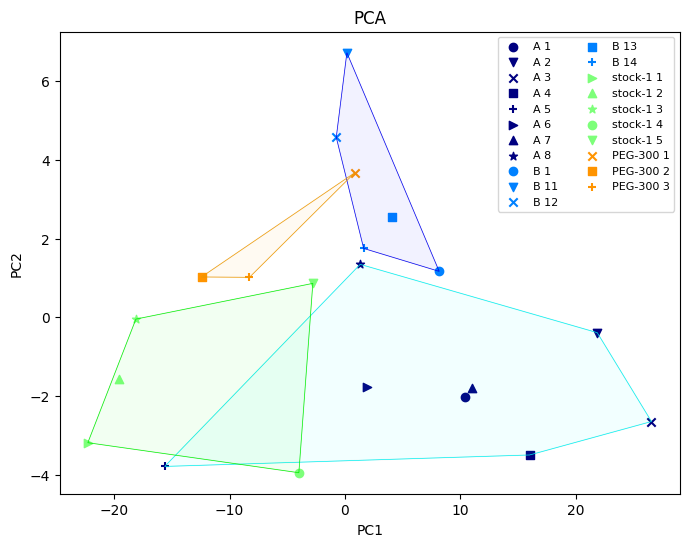

In [10]:

# https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/
from scipy.spatial import ConvexHull
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    

nc = 5
pca2 = pca(n_components=nc)
 
# Transform on the scaled features
Xt2 = pca2.fit_transform(n_spectra_sm)


# Разные стили точек, чтобы циклом по-очереди присваивались и проще различать было бы.
symb = ['o','v','x','s','+','>','^','*'] 

plt.figure(figsize=(8,6))
for j in range(len(Xt2[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    xi = Xt2[j,0]
    yi = Xt2[j,1]
    plt.scatter(xi, yi, c=col, label=labplot[j], marker = symb[j % len(symb)])


colors2 = ['cyan', 'blue', 'lime', 'orange']
for n, i in enumerate(groups):
#    col = np.expand_dims(np.array(colors[groups[n][0]]), axis=0)
#    plt.plot(wl, spectra[groups[n],:].mean(0).T, c=col, label=labels[n])
    encircle(Xt2[groups[n],0], Xt2[groups[n],1], ec=colors2[n], fc="none", linewidth=0.5)
    encircle(Xt2[groups[n],0], Xt2[groups[n],1], ec="k", fc=colors2[n], alpha=0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labplot, ncol=2, fontsize="8")
plt.title('PCA')
plt.show()

или вводить правила для классификации...

Или можно нарисовать спектры РС, в общем это может показать какие фрагменты спектра вносят вклад.///

(как тут https://www.hou.usra.edu/meetings/informatics2018/pdf/6045.pdf и https://www.researchgate.net/publication/261734528_Cell_death_stages_in_single_apoptotic_and_necrotic_cells_monitored_by_Raman_microspectroscopy )

Тут тоже  пример https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html

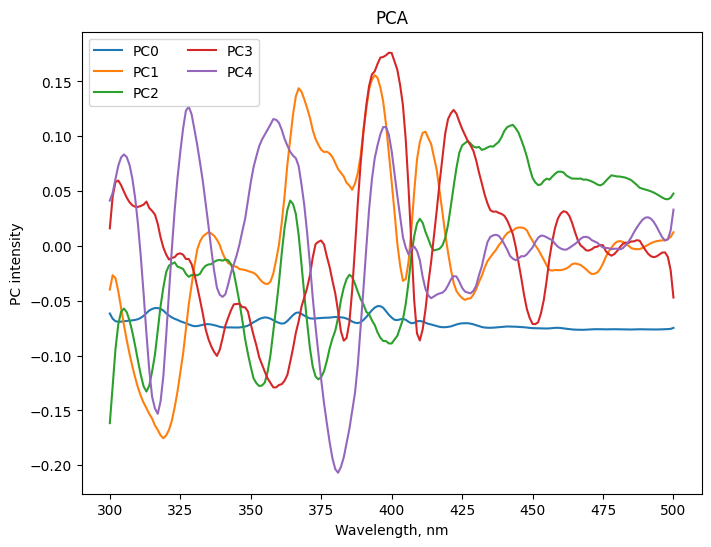

In [11]:
plt.figure(figsize=(8,6))
for i in range(nc):
    plt.plot(wl, pca2.components_[i], label="PC" + str(i))
#    plt.plot(wl, pca2.components_[i] + 0.15 * i, label="PC" + str(i))


plt.xlabel('Wavelength, nm')
plt.ylabel('PC intensity')
plt.legend(loc='upper left', ncol=2) # labplot,
plt.title('PCA')
plt.show()

Еще можно построить матрицу корреляции значений РС и параметров измерения (для чего добавить РС в датафрейм, или создать новый). correlation matrix
(https://nirpyresearch.com/nir-data-correlograms-seaborn-python

Или что-то про декомпозицию https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

## EMPCA или WPCA

Если данные неполные (спектры записаны в разных диапазонах), или избыточно зашумлены, то может пригодиться EMPCA или WPCA.

## EMPCA

EMPCA https://github.com/sbailey/empca/tree/master

"EMPCA: Weighted Expectation Maximization Principal Component Analysis.

Classic PCA is great but it doesn't know how to handle noisy or missing data properly. This module provides Weighted Expectation Maximization PCA, an iterative method for solving PCA while properly weighting data. Missing data is simply the limit of weight=0."


In [12]:
import empca
m = empca.empca(spectra_sm, silent=True)

Добавил "-" чтобы инвертировать по х и сделать похожим на график выше.

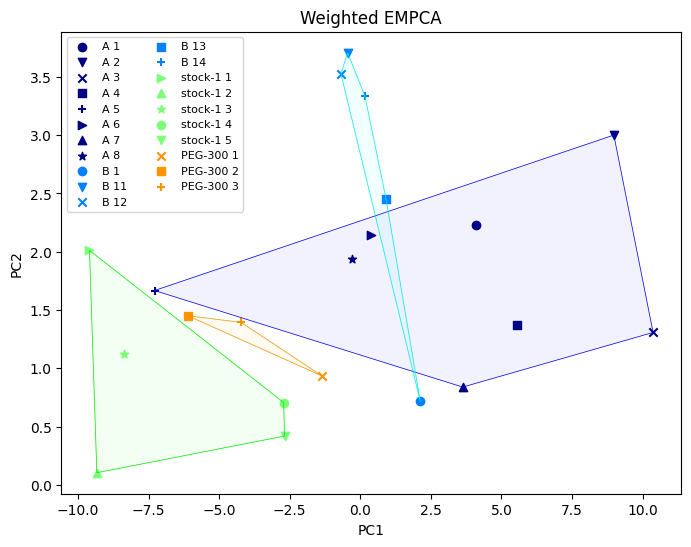

In [21]:
plt.figure(figsize=(8,6))
for j in range(len(m.data[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    xi = m.coeff[j,0]
    yi = m.coeff[j,1]
    plt.scatter(-xi, yi, c=col, label=labplot[j], marker = symb[j % len(symb)])


colors2 = ['blue', 'cyan', 'lime', 'orange']
for n, i in enumerate(groups):
    encircle(-m.coeff[groups[n],0], m.coeff[groups[n],1], ec=colors2[n], fc="none", linewidth=0.5)
    encircle(-m.coeff[groups[n],0], m.coeff[groups[n],1], ec="k", fc=colors2[n], alpha=0.05)


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labplot, ncol=2, fontsize="8")
plt.title('Weighted EMPCA')
plt.show()

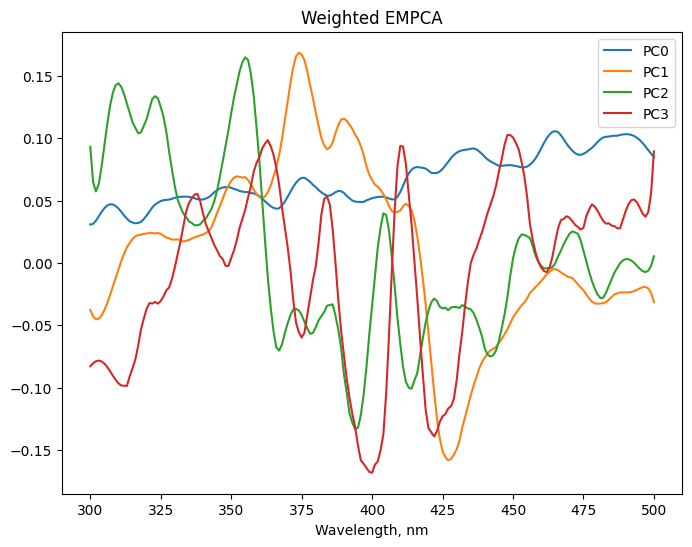

In [14]:
plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(wl,  m.eigvec[i], label="PC" + str(i))

plt.xlabel('Wavelength, nm')
plt.legend(loc='upper right')
plt.title('Weighted EMPCA')
plt.show()

А если брать несглаженные данные?

In [15]:
m = empca.empca(spectra, silent=True)

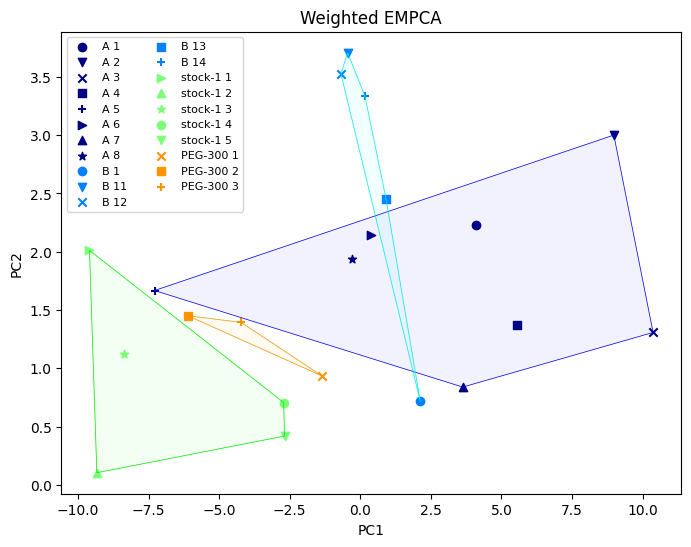

In [22]:
plt.figure(figsize=(8,6))
for j in range(len(m.data[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    xi = m.coeff[j,0]
    yi = m.coeff[j,1]
    plt.scatter(-xi, yi, c=col, label=labplot[j], marker = symb[j % len(symb)])

for n, i in enumerate(groups):
    encircle(-m.coeff[groups[n],0], m.coeff[groups[n],1], ec=colors2[n], fc="none", linewidth=0.5)
    encircle(-m.coeff[groups[n],0], m.coeff[groups[n],1], ec="k", fc=colors2[n], alpha=0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labplot, ncol=2, fontsize="8")
plt.title('Weighted EMPCA')
plt.show()

Хуже вроде не стало.

## WPCA - еще более навороченный вариант

https://github.com/jakevdp/wpca

- ``wpca.WPCA`` uses a direct decomposition of a weighted covariance matrix to
  compute principal vectors, and then a weighted least squares optimization
  to compute principal components. It is based on the algorithm presented
  in "Weighted principal component analysis: a weighted covariance eigendecomposition approach" [Delchambre (2014)](http://arxiv.org/abs/1412.4533)

- ``wpca.EMPCA`` uses an iterative expectation-maximization approach to solve
  simultaneously for the principal vectors and principal components of
  weighted data. It is based on the algorithm presented in "Principal Component Analysis with Noisy and/or Missing Data"
  [Bailey (2012)](http://arxiv.org/abs/1208.4122).

- ``wpca.PCA`` is a standard non-weighted PCA implemented using the singular
  value decomposition. It is mainly included for the sake of testing.

In [17]:
from wpca import WPCA

# https://notebook.community/jakevdp/wpca/WPCA-Example
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb

wpca = WPCA(n_components=5)
Xt = wpca.fit_transform(spectra)
Y = WPCA(n_components=3).fit_reconstruct(spectra) # , **kwds

тут по другой оси инвертировал

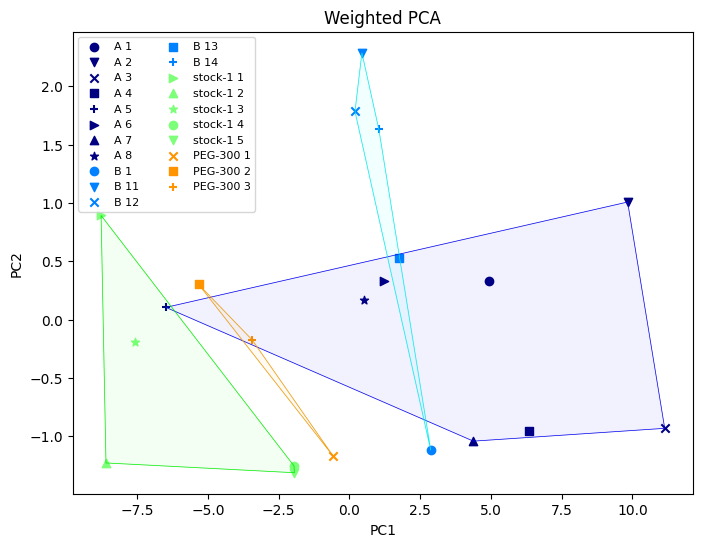

In [23]:
plt.figure(figsize=(8,6))
for j in range(len(Xt2[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    xi = Xt[j,0]
    yi = Xt[j,1]
    plt.scatter(xi, -yi, c=col, label=labplot[j], marker = symb[j % len(symb)])

for n, i in enumerate(groups):
    encircle(Xt[groups[n],0], -Xt[groups[n],1], ec=colors2[n], fc="none", linewidth=0.5)
    encircle(Xt[groups[n],0], -Xt[groups[n],1], ec="k", fc=colors2[n], alpha=0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(labplot,ncol=2, fontsize="8") # loc='lower left', 
plt.title('Weighted PCA')
plt.show()

Лучше или хуже - непонятно.

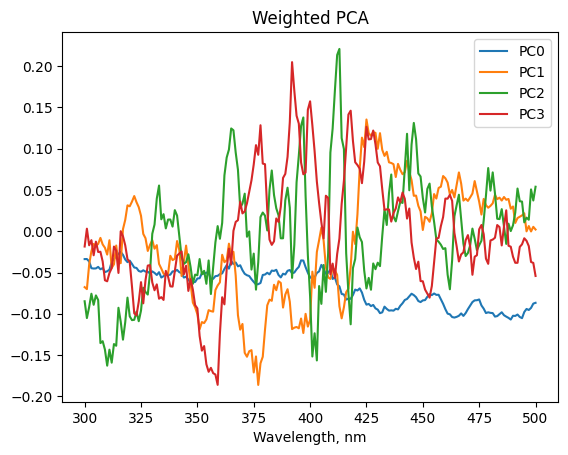

In [19]:
for i in range(4):
    plt.plot(wl,  wpca.components_[i], label="PC" + str(i))

plt.xlabel('Wavelength, nm')
plt.legend(loc='upper right')
plt.title('Weighted PCA')
plt.show()

И пример восстановление спектров из пяти компонент. Шумов меньше, это понятно.

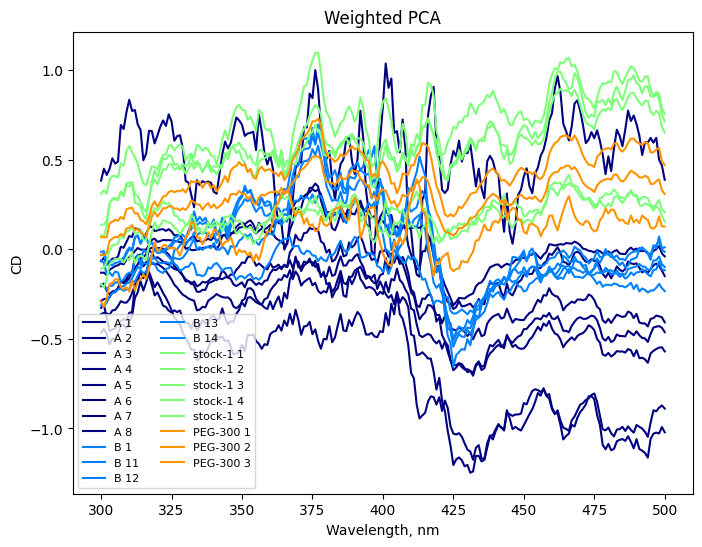

In [20]:
plt.figure(figsize=(8,6))
for j in range(len(Y[:,0])):
    col = np.expand_dims(np.array(colors[j]), axis=0)
    plt.plot(wl, Y[j].T, c=col, label=labplot[j])
plt.xlabel('Wavelength, nm')
plt.ylabel('CD')
plt.legend(labplot, ncol=2, fontsize="8") # ,loc='upper left'
plt.title('Weighted PCA')
plt.show()

От графиков PC1/PC2 до МО (класификация и распознавание) буквально один шаг - ввести правила разграничения групп.
Тогда надо вводить в рассмотрение дополнительную колонку, указывающую на принадлежность к группам (и по ней окрашивать одним цветом).


И еще можно выделить какая именно часть вносит вклад в компоненты (
https://nirpyresearch.com/pca-correlation-circle/)